In [36]:
# This file uses a utils.py file for storing functions.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import grangercausalitytests
from arch.unitroot import ADF, PhillipsPerron, KPSS
from sklearn.metrics import confusion_matrix
from utils import *
import warnings
# we ignore deprecation warnings and futurewarnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Exercise 3.1

* Import the data set with the necessary variables saved in Exercises 2. 
* apply quantile regression for the median (quantile = 0.5) in a full sample
* apply rolling quantile regression for the median (quantile = 0.5) with a window of selected size. Do NOT do it every minute
* plot the rolling estimates of the slope coefficient with a reference line of the full-sample estimate

In [3]:
# 3.1.1 IMPORT
# we load a dataset with APPL and META prices and returns
# saved into a pickle file at the end of the last lab
file_path = "dataUSA_MSFT_NVDA.pkl"
dataUSA_MSFT_NVDA = pd.read_pickle(file_path)
dataUSA_MSFT_NVDA


,close_MSFT,close_NVDA,r_MSFT,r_NVDA,time,r_MSFT_rolling_std,r_diff_MSFT_NVDA,r_diff_MSFT_rolling_std,rollcorr90_r_MSFT_NVDA
timestamp,,,,,,,,,
2025-01-02 09:32:00,424.2551,137.5285,17.613405,85.055874,2025-01-02 09:32:00,NaN,-67.442469,NaN,NaN
2025-01-02 09:33:00,422.8256,137.3785,-33.751244,-10.912782,2025-01-02 09:33:00,NaN,-22.838461,NaN,NaN
2025-01-02 09:34:00,422.1233,136.7164,-16.623494,-48.311828,2025-01-02 09:34:00,NaN,31.688334,NaN,NaN
2025-01-02 09:35:00,422.1034,136.5386,-0.471437,-13.013487,2025-01-02 09:35:00,NaN,12.542050,NaN,NaN
2025-01-02 09:36:00,422.1432,136.1687,0.942852,-27.128003,2025-01-02 09:36:00,NaN,28.070856,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-09-30 15:56:00,517.5900,186.4250,-6.952894,-14.740371,2025-09-30 15:56:00,3.336294,7.787477,5.622656,0.365647
2025-09-30 15:57:00,517.6600,186.4050,1.352330,-1.072875,2025-09-30 15:57:00,3.291362,2.425205,5.603586,0.364607
2025-09-30 15:58:00,518.0250,186.5450,7.048475,7.507709,2025-09-30 15:58:00,3.335412,-0.459234,5.579016,0.376579


In [4]:
# We dont need the columns with difference anymore
dataUSA_MSFT_NVDA = dataUSA_MSFT_NVDA.iloc[:, ~dataUSA_MSFT_NVDA.columns.str.contains("_diff_")]


In [7]:
# 3.1.2 Quantile Regression for the median in the full sample
# Now we are estimating quantile regression at median
# The fitted line here is chosen so that 50% of the residuals are above and 50% below the line 
# i.e. it estimates the median of y_t  given X_t

X =  dataUSA_MSFT_NVDA["r_MSFT"]
y =  dataUSA_MSFT_NVDA["r_NVDA"]
X = sm.add_constant(X)
model_qr_median = sm.QuantReg(y,X).fit(q = 0.5)
print(model_qr_median.summary())

                         QuantReg Regression Results                          
Dep. Variable:                 r_NVDA   Pseudo R-squared:               0.1254
Model:                       QuantReg   Bandwidth:                      0.7867
Method:                 Least Squares   Sparsity:                        15.74
Date:                Sun, 02 Nov 2025   No. Observations:                72539
Time:                        18:18:15   Df Residuals:                    72537
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0399      0.029      1.367      0.172      -0.017       0.097
r_MSFT         0.9570      0.003    300.101      0.000       0.951       0.963


Interpretation : We clearly see that the model suggests that a one unit increase in the median return of MSFT raises the median return on NVDA by 0.9570 units. The constant is not significant.

In [ ]:
# 3.1.3
window = 60
slopes = []
for i in range(window, len(y)):
    res = sm.QuantReg(y[i-window:i], X[i-window:i]).fit(q=0.5)
    slopes.append(res.params['r_MSFT'])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  w

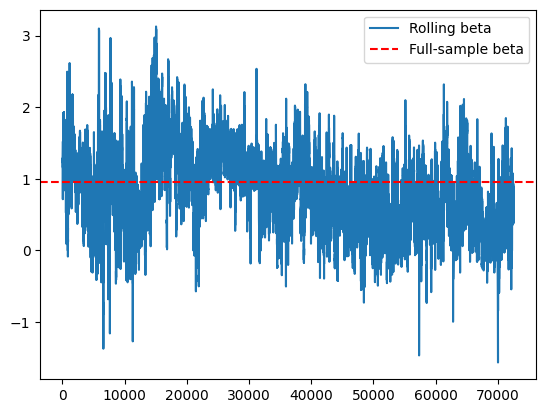

In [ ]:

import matplotlib.pyplot as plt

plt.plot(range(window, len(y)), slopes, label='Rolling beta')
plt.axhline(y=model_qr_median.params['r_MSFT'], color='r', linestyle='--', label='Full-sample beta')
plt.legend(); plt.show()



In [30]:
# Extra analysis before commensing with Exercise 3.2
# Engel granger test on residuals
from utils import eg_adf_pvalue 
df_M_N = dataUSA_MSFT_NVDA[["close_MSFT", "close_NVDA"]]

pvalue_adf = eg_adf_pvalue(df_M_N, "close_MSFT", "close_NVDA")

print("p_value from Engle-Granger residual test (ADF) : ", pvalue_adf)

p_value from Engle-Granger residual test (ADF) :  0.07392898045361164


The Engle–Granger residual test (ADF) estimates:

$$
\varepsilon_t = \rho \varepsilon_{t-1} + u_t
$$

where the null hypothesis is $( H_0 : \rho = 1 )$ (residuals have a unit root, no cointegration).


# Exercise 3.2

* test for Granger causality in both directions within a window of selected size. Do NOT do it every minute
* compute the proportion of causality findings at 5% significance level in both directions
* check with a contingency table how many times we have both rejections, none or only one-sided rejection

In [20]:
######### 3.2

# Granger Causality test
# Does NVDA granger cause MSFT?
print("We check if NVDA prices Granger-cause MSFT prices")
granger_test_M_N = grangercausalitytests(dataUSA_MSFT_NVDA[["close_MSFT", "close_NVDA"]], maxlag = [10])
print("\n")

# Does NVDA granger cause MSFT?
print("We check if NVDA prices Granger-cause MSFT prices")
granger_test_N_M = grangercausalitytests(dataUSA_MSFT_NVDA[["close_NVDA", "close_MSFT"]], maxlag = [10])


We check if NVDA prices Granger-cause MSFT prices

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=9.6984  , p=0.0000  , df_denom=72508, df_num=10
ssr based chi2 test:   chi2=97.0121 , p=0.0000  , df=10
likelihood ratio test: chi2=96.9473 , p=0.0000  , df=10
parameter F test:         F=9.6984  , p=0.0000  , df_denom=72508, df_num=10


We check if NVDA prices Granger-cause MSFT prices

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5906  , p=0.1024  , df_denom=72508, df_num=10
ssr based chi2 test:   chi2=15.9107 , p=0.1022  , df=10
likelihood ratio test: chi2=15.9090 , p=0.1023  , df=10
parameter F test:         F=1.5906  , p=0.1024  , df_denom=72508, df_num=10


The Granger causality test estimates:

$$
y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i y_{t-i} + \sum_{i=1}^{p} \beta_i x_{t-i} + \varepsilon_t
$$

and tests $ H_0 : \beta_1 = \beta_2 = \cdots = \beta_p = 0 $,  
i.e., whether past values of $x_t$ (MSFT) **do not Granger-cause** $y_t$ (NVDA).
INTERPRETATION:
ADF p = 0.0739 > 0.05 
Since residuals are non-stationary there is **no cointegration**.  
However, Granger p = 0.0000 < 0.05 suggests that **MSFT Granger-causes NVDA** in short-run dynamics.
MSFT helps predict NVDA’s movements in the short run, but the two price series **do not share a long-run equilibrium relationship**.


In [32]:
# 3.2.1 Rolling Granger Causality test setup and imports.

from utils import eg_adf_pvalue, eg_pp_pvalue ,eg_kpss_pvalue 
from utils import granger_pvalue

df_M_N = dataUSA_MSFT_NVDA[["close_MSFT", "close_NVDA"]]
pvalues = (eg_adf_pvalue(df_M_N, "close_MSFT", "close_NVDA"),
           eg_pp_pvalue(df_M_N, "close_MSFT", "close_NVDA"),
           eg_kpss_pvalue(df_M_N, "close_MSFT", "close_NVDA"))

print("p-values from Engle-Granger residual tests (ADF, PP, KPSS):", pvalues)



p-values from Engle-Granger residual tests (ADF, PP, KPSS): (0.07392898045361164, 0.09151838900958936, 0.0001)


In [ ]:
## Rolling Granger Causality Test
# MSFT to NVDA
_granger1 = lambda x: granger_pvalue(df_M_N.loc[x.index], "close_MSFT", "close_NVDA", maxlag = 10)

# NVDA to MSFT
_granger2 = lambda x: granger_pvalue(df_M_N.loc[x.index], "close_NVDA", "close_MSFT",maxlag = 10)

granger_pvalues_MSFT_to_NVDA = df_M_N["close_MSFT"].rolling(window = 60, step = 15).apply(_granger1)
granger_pvalues_NVDA_to_MSFT = df_M_N["close_NVDA"].rolling(window = 60, step = 15).apply(_granger2)

granger_pvalues = pd.concat([granger_pvalues_MSFT_to_NVDA.rename("p_value_NVDA_to_MSFT"),
                             granger_pvalues_NVDA_to_MSFT.rename("p_value_MSFT_to_NVDA")],
                             axis=1).dropna()
print(granger_pvalues)



                     p_value_NVDA_to_MSFT  p_value_MSFT_to_NVDA
timestamp                                                      
2025-01-02 10:32:00              0.700567              0.181579
2025-01-02 10:47:00              0.458078              0.534343
2025-01-02 11:02:00              0.232558              0.210260
2025-01-02 11:17:00              0.011699              0.180318
2025-01-02 11:32:00              0.513387              0.331197
...                                   ...                   ...
2025-09-30 14:47:00              0.031149              0.338509
2025-09-30 15:02:00              0.045404              0.123157
2025-09-30 15:17:00              0.671325              0.426115
2025-09-30 15:32:00              0.459859              0.415287
2025-09-30 15:47:00              0.567106              0.102289

[4832 rows x 2 columns]


In [23]:
# 3.2.2
# how often do we find causality (reject the null hypothesis) at 5% significance level?
rejections_NVDA_to_MSFT = (granger_pvalues["p_value_NVDA_to_MSFT"] < 0.05).sum()/len(granger_pvalues)
rejections_MSFT_to_NVDA = (granger_pvalues["p_value_MSFT_to_NVDA"] < 0.05).sum()/len(granger_pvalues)
print("Proportion of NVDA causes MSFT:", rejections_NVDA_to_MSFT)
print("Proportion of MSFT causes NVDA:", rejections_MSFT_to_NVDA)

Proportion of NVDA causes MSFT: 0.12065397350993377
Proportion of MSFT causes NVDA: 0.1115480132450331


In [25]:
# 3.2.3
# check with a contingency table how many times
# we have both rejections, none or only one-sided rejection

confusion_mat = confusion_matrix(
    granger_pvalues["p_value_NVDA_to_MSFT"] < 0.05,
    granger_pvalues["p_value_MSFT_to_NVDA"] < 0.05
)
# add labels of rows and columns
confusion_mat_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat),
                                index=["NVDA does NOT cause MSFT", "NVDA causes MSFT"],
                                columns=["MSFT does NOT cause NVDA", "MSFT causes NVDA"])

print("Contingency table of results of Granger causality tests:")
print(confusion_mat_df)


Contingency table of results of Granger causality tests:
                          MSFT does NOT cause NVDA  MSFT causes NVDA
NVDA does NOT cause MSFT                  0.797185          0.082161
NVDA causes MSFT                          0.091267          0.029387


# Exercise 3.3

* test for cointegration (ADF, PP, KPSS) in the full sample - interpret the results
* test for cointegration (ADF, PP, KPSS) within a rolling window of selected size. Do NOT do it every minute
* plot the p-values of the tests within the rolling window
* check how often the cointegration is found at 5% significance level for each test

In [26]:
# 3.3.1
# Testing Cointegration 
X_price = dataUSA_MSFT_NVDA["close_MSFT"] 
y_price = dataUSA_MSFT_NVDA["close_NVDA"] 

X_price = sm.add_constant(X_price)
model_ols_p = sm.OLS(y_price, X_price).fit()
print (model_ols_p.summary())

# Are the residuals stationary? Spoiler Alert: No, we have a high p value
residuals = model_ols_p.resid
adf_test2 = ADF(residuals, lags = 5, trend = 'c')
print(adf_test2.summary().as_text())


                            OLS Regression Results                            
Dep. Variable:             close_NVDA   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                 5.665e+05
Date:                Sun, 02 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:17:33   Log-Likelihood:            -2.6091e+05
No. Observations:               72539   AIC:                         5.218e+05
Df Residuals:                   72537   BIC:                         5.219e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -70.6197      0.285   -247.553      0.0

They are not cointegrated

In [ ]:
# 3.3.2 Rolling Cointegration Test
_adf = lambda x: eg_adf_pvalue(df_M_N.loc[x.index], "close_MSFT", "close_NVDA")
_pp  = lambda x: eg_pp_pvalue(df_M_N.loc[x.index], 
                              "close_MSFT", "close_NVDA")
_kpss= lambda x: eg_kpss_pvalue(df_M_N.loc[x.index], 
                                "close_MSFT", "close_NVDA")

# we apply the test every 60 minutes on a 240 minute window
adf_p = df_M_N["close_NVDA"].rolling(window = 240, step = 60).apply(_adf)
pp_p  = df_M_N["close_NVDA"].rolling(window = 240, step = 60).apply(_pp)
kpss_p= df_M_N["close_NVDA"].rolling(window = 240, step = 60).apply(_kpss)

out = pd.concat({"adf_p": adf_p, "pp_p": pp_p, "kpss_p": kpss_p}, axis=1).dropna()


<Axes: xlabel='timestamp'>

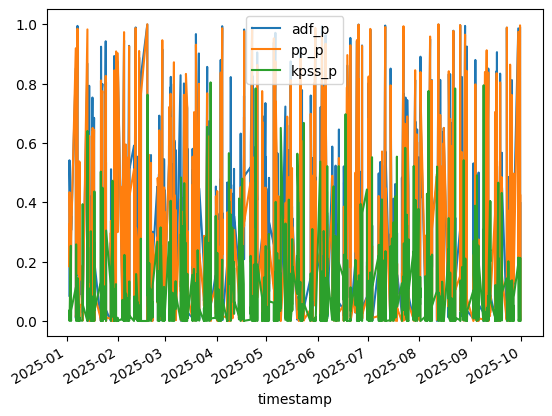

In [28]:
# 3.3.3 
out.plot()


In [ ]:
# 3.3.4
# lets check how many times would we identify cointegration at 5% significance level?
print("Share of times cointegration identified at 5% significance level:")
print("ADF test:", (out["adf_p"] < 0.05).sum()/out.size)
print("PP test:", (out["pp_p"] < 0.05).sum()/out.size)
print("KPSS test:", (out["kpss_p"] > 0.05).sum()/out.size)


Share of times cointegration identified at 5% significance level:
ADF test: 0.06639004149377593
PP test: 0.09820193637621023
KPSS test: 0.13526970954356846


# Exercise 3.4 *

The Granger causality test is performed based on a linear regression model:

$$y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i y_{t-i} + \sum_{j=1}^{p} \beta_j x_{t-j} + \epsilon_t$$

The null hypothesis is that the coefficients $\beta_i$ are jointly equal to zero:

$$H_0: \beta_1 = \beta_2 = ... = \beta_p = 0$$

 If we reject the null hypothesis, we conclude that $x$ Granger-causes $y$.

It is tested with an F-test based on the sum of squared residuals from the unrestricted model (with lags $x$ included) and the restricted model (without lags of $x$).

$$F = \frac{(SSR_{R} - SSR_{UR})/p}{SSR_{U}/(n - 2p - 1)}$$

where $SSR_{R}$ is the sum of squared residuals from the restricted model (when the null hypothesis is true), $SSR_{U}$ is the sum of squared residuals from the unrestricted (full) model, $p$ is the number of lags (2p is the total number of regressors), and $n$ is the number of observations.

The results of the rollingOLS function include SSR values, so we can use them to calculate rolling Granger causality p-values more efficiently.

Check the code:
```python
rolling_results.ssr.tail()
```
and write a function that calculates rolling Granger causality p-values based on the SSR values from two rolling OLS results (one for the restricted model and one for the unrestricted model).

In [34]:
# 3.4.1
from scipy.stats import f

def rolling_granger_pvalue(ssr_r, ssr_ur, p, n):
    F = ((ssr_r - ssr_ur) / p) / (ssr_ur / (n - 2*p - 1))
    return 1 - f.cdf(F, p, n - 2*p - 1)


<Axes: title={'center': 'Rolling Granger causality p-values (MSFT causing NVDA)'}>

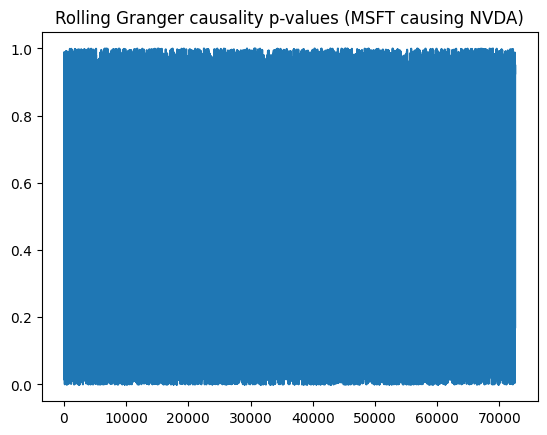

In [35]:

# unrestricted model: includes lags of both MSFT and NVDA
rolling_ur = RollingOLS(dataUSA_MSFT_NVDA["close_NVDA"], 
                        sm.add_constant(dataUSA_MSFT_NVDA[["close_NVDA", "close_MSFT"]].shift(1)),
                        window=60).fit()

# restricted model: includes only NVDA lags (no MSFT)
rolling_r = RollingOLS(dataUSA_MSFT_NVDA["close_NVDA"], 
                       sm.add_constant(dataUSA_MSFT_NVDA["close_NVDA"].shift(1)),
                       window=60).fit()

# compute p-values
pvals = rolling_granger_pvalue(rolling_r.ssr, rolling_ur.ssr, p=1, n=60)
pvals = pd.Series(rolling_granger_pvalue(rolling_r.ssr, rolling_ur.ssr, p=1, n=60))
pvals.plot(title="Rolling Granger causality p-values (MSFT causing NVDA)")



# EXTRA NOTES:

The Engle–Granger residual test (ADF) estimates:

$$
\varepsilon_t = \rho \varepsilon_{t-1} + u_t
$$

where the null hypothesis is $( H_0 : \rho = 1 )$ (residuals have a unit root, no cointegration).
